## Articles from the Guardian

Looking at The Guardian's coverage of Facebook & Cambrdige Analytica from `18-03-2018` to the `24-03-2018`.

query:

    facebook AND cambridge analytica

How would it be best to analyse there content? What to I want to find out? What do I think that might be helpful to this project? To start it might be intersting to see the themes that were present in the coverage for that I can just take the text content of the article. I am aware that there are quite a few attributes that come with the articles, im not sure what these are so will load a line of the file and see what we have to work with.

In [2]:
import json
import re
import pprint
import collections

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

plt.style.use('seaborn-pastel')

# local modules
from utils import data_path, cat, iter_ndjson

filepath = "{}guardian/date_range.ndjson".format(data_path)

eg = next(iter_ndjson(filepath))[1]

So the api provides info on their data structures (http://open-platform.theguardian.com/documentation/search) but many of these are optional and I cant remeber which ones I requested. 

In [3]:
def print_attrs(data, tab=0):
    for k, v in data.items():
        rep = "{}{}".format("\t"*tab,k)
        print(rep)
        if isinstance(v, dict):
            print_attrs(v, tab=tab+1)
        if isinstance(v, list):
            print("{}[".format("\t"*tab,k))
            if v: print_attrs(v[0], tab=tab+1)
            print("{}]".format("\t"*tab,k))

print_attrs(eg)

isHosted
tags
[
	apiUrl
	webTitle
	type
	sectionId
	id
	webUrl
	sectionName
	references
	[
	]
]
fields
	lang
	lastModified
	newspaperPageNumber
	commentable
	productionOffice
	main
	commentCloseDate
	newspaperEditionDate
	shouldHideAdverts
	firstPublicationDate
	thumbnail
	charCount
	bodyText
	isPremoderated
	publication
	headline
	showInRelatedContent
	body
	byline
	shortUrl
	trailText
	shouldHideReaderRevenue
	legallySensitive
	isInappropriateForSponsorship
	standfirst
	wordcount
sectionName
id
pillarName
apiUrl
webTitle
type
pillarId
webPublicationDate
webUrl
sectionId


In [4]:
print(eg["fields"]["standfirst"])

<p>Whistleblower describes how firm linked to former Trump adviser Steve Bannon compiled user data to target American voters</p><ul><li><a href="https://www.theguardian.com/news/2018/mar/17/data-war-whistleblower-christopher-wylie-faceook-nix-bannon-trump">‘I made Steve Bannon’s psychological warfare tool’: meet the data war whistleblower</a><br></li><li><a href="https://www.theguardian.com/technology/2018/mar/21/mark-zuckerberg-response-facebook-cambridge-analytica">Mark Zuckerberg breaks silence on Cambridge Analytica</a><br></li></ul>


In [5]:
def remove_tags(raw_html):
    "remove html tags"
    return re.sub(tag_pattern, '.', raw_html)

tag_pattern = re.compile('<.*?>|nbsp')

In [6]:
print(eg["fields"]["headline"])
print(eg["webTitle"])
print(remove_tags(eg["fields"]["standfirst"]))

Revealed: 50 million Facebook profiles harvested for Cambridge Analytica in major data breach
Revealed: 50 million Facebook profiles harvested for Cambridge Analytica in major data breach
.Whistleblower describes how firm linked to former Trump adviser Steve Bannon compiled user data to target American voters....‘I made Steve Bannon’s psychological warfare tool’: meet the data war whistleblower.....Mark Zuckerberg breaks silence on Cambridge Analytica....


In [7]:
def plot_counter(counter, n=15, title=None, size=(5,6)):
    labels, values = list(zip(*counter.most_common(n)[::-1]))
    fig, ax = plt.subplots()
    ind = np.arange(len(labels))
    fig.set_size_inches(*size)
    width = 0.8
    a = ax.barh(ind, values, width)
    ax.set_yticks(ind)
    ax.set_yticklabels(labels)
    ax.legend(a, ("counts",))
    if title is not None:
        ax.set_title(title, y=1.05)
    plt.show()

### Tag use:

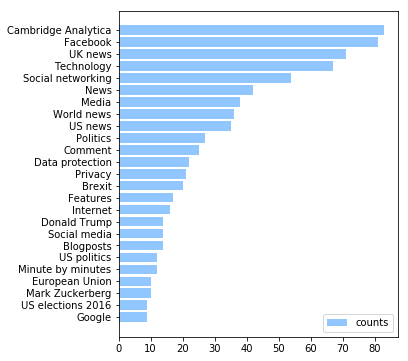

total tags:  1163
unique tags:  228


In [8]:
c = collections.Counter()
for ndline in iter_ndjson(filepath):
    for item in ndline:
        for tag in item["tags"]:
            c[tag['webTitle']] += 1

plot_counter(c, 25)
print("total tags: ", sum(c.values()))
print("unique tags: ", len(c))


## The data wanted

peusdo struct of how to construct the data.

    article {
        published       date
        webTitle        string
        headline        string
        bodyText        string
        standfirst      html    - remove html make string
        wordCount       int
    }  

In [9]:
date = 17
total = 0
for ndline in iter_ndjson(filepath):
    print("2018-{}-03 Total: {}".format(date,len(ndline)))
    date += 1
    total += len(ndline)
    
print("total:", total)

2018-17-03 Total: 5
2018-18-03 Total: 9
2018-19-03 Total: 17
2018-20-03 Total: 17
2018-21-03 Total: 26
2018-22-03 Total: 22
2018-23-03 Total: 18
2018-24-03 Total: 10
total: 124


## Generating Keywords with R.A.K.E algorithm.

After implementing my interpretation of the R.A.K.E (rapid automatic keyword extraction) algorithm described in `'Rose, S. Engel, D. Cramer, N. and Cowley, W. 2010. Automatic keyword extraction from individual documents'` for generating keywords from rss feeds I now have another reasonable place to try it out here.

In [10]:
import rake

with open('../resources/more_stopwords.txt') as fp:
    stopwords = set(fp.read().split())

In [11]:

texts = []
for ndline in iter_ndjson(filepath):
    for item in ndline:
        text = ". ".join([item["webTitle"], item["fields"]["bodyText"]])
        texts.append(text)

kw_extractor = rake.KeywordExtractor(stopwords)
scores = rake.CollectionOperator(kw_extractor, texts).fit()

### Generated Keywords

Because the algorithm prioritieses longer keywords within the text I think its not supprising to see that facebook has not made it in the list. but interms of bigrams the results seem to make sense in relation to the keywords presented by the guardian.

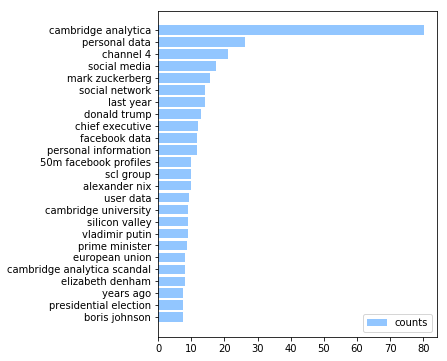

In [12]:
plot_counter(collections.Counter(scores), 25)

In [13]:
def plot_ngrams(text, n0, n1, n_features=10000, filter_fn=None):
    z = max(n1 - n0,2)
    fig, axis = plt.subplots(1, z)
    fig.set_size_inches(10, 5)
    for i in range(z):
        tfidf_vect = TfidfVectorizer(max_df=0.5, min_df=2, 
                                     max_features=n_features,
                                     ngram_range=(n0 + i, n0 + i + 1),
                                     stop_words="english")
        tfidf_features = tfidf_vect.fit_transform(text)
        vocab = tfidf_vect.get_feature_names()
        values = tfidf_features.toarray().sum(axis=0)
        if filter_fn:
            sample = [(values[i], k) for i, k in enumerate(vocab) if filter_fn(k)]
        else:
            sample = [(values[i], k) for i, k in enumerate(vocab)]
        v, k = zip(*sorted(sample, reverse=True)[:20])
        dd = pd.DataFrame(index=k, data={"key": k, "tfidf": v})
        dd.plot(kind="barh", ax=axis[i], legend=False).invert_yaxis()
    plt.tight_layout()
    plt.show()

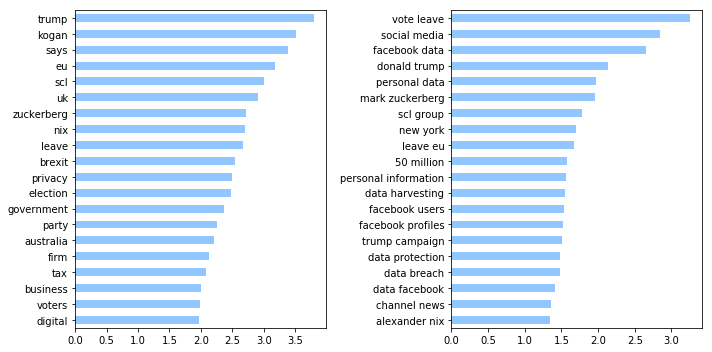

In [14]:
plot_ngrams(texts, 1, 2) 

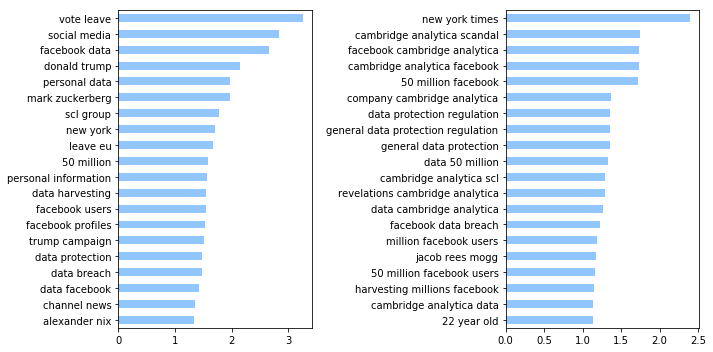

In [15]:
plot_ngrams(texts, 2, 3) 

In [16]:
def plot_ngrams2(text, n0, n1, n_features=10000, filter_fn=None):
    z = max(n1 - n0, 2)
    fig, axis = plt.subplots(1, z)
    fig.set_size_inches(10, 5)
    for i in range(z):
        tf_vect = CountVectorizer(max_df=0.5, min_df=2, 
                                     max_features=n_features,
                                     ngram_range=(n0 + i, n0 + i + 1),
                                     stop_words="english")
        tf_features = tf_vect.fit_transform(text)
        vocab = tf_vect.get_feature_names()
        values = tf_features.toarray().sum(axis=0)
        if filter_fn:
            sample = [(values[i], k) for i, k in enumerate(vocab) if filter_fn(k)]
        else:
            sample = [(values[i], k) for i, k in enumerate(vocab)]
        v, k = zip(*sorted(sample, reverse=True)[:20])
        dd = pd.DataFrame(index=k, data={"key": k, "counts": v})
        dd.plot(kind="barh", ax=axis[i], legend=False).invert_yaxis()
    plt.tight_layout()
    plt.show()

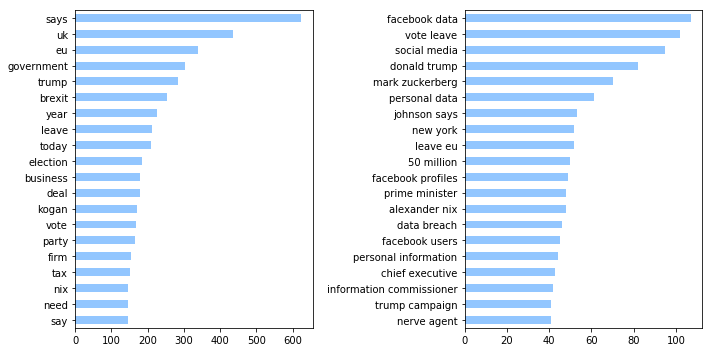

In [17]:
plot_ngrams2(texts, 1, 2) 

In [18]:
import topic_graph

graph = topic_graph.topic_graph(texts, max_iter=50, stop_words=stopwords)
out = "../../gh-pages/_data/newsgraph.json"

with open(out, "w") as f:
    json.dump(graph, f, indent=4, sort_keys=True)
print("saved result to", out)

Fitting CountVectorizer...
Fitting LDA models with tf features, 
max_iter=50. number of topics=5. n_samples=25. features_shape=(124, 1359)...
This may take a while...
Model fitted in: 4.71 secs
#### topic: 0
facebook(1074.25), data(846.96), cambridge(447.63), analytica(405.88), company(274.55), information(250.57), people(242.17), trump(181.52), users(177.52), political(166.83), kogan(153.31), social(139.17), time(122.06), zuckerberg(119.18), media(118.13), personal(106.81), companies(97.95), campaign(94.60), privacy(94.53), digital(91.62), profiles(88.80), advertising(86.46), voters(82.56), research(82.42), guardian(79.55), 
#### topic: 1
data(1.29), cambridge(1.12), facebook(0.88), analytica(0.87), people(0.69), kogan(0.68), information(0.62), campaign(0.57), company(0.57), political(0.53), uk(0.53), guardian(0.52), trump(0.48), eu(0.48), world(0.47), time(0.47), users(0.46), government(0.46), work(0.45), university(0.45), make(0.45), democracy(0.44), told(0.44), voters(0.43), person